A common problem in encountered when trying to collect a set of publications from multiple researchers (e.g. a network of researchers working on a similar topic or using a shared facility) is the manual labor required to identify and vet the publications. This process often requires a significant exertion of manual labor and is prone to inconsistent results. A typical work flow in carrying out this task is for one or more people to search for publications (e.g. in Google Scholar) and then manually inspect each one to determine relevance. The search component of this process can be automated but, depending on the input available (e.g. the search terms used in the query), it may return a significant number of false positives. The manual labor needed to vet each publication is still too high to be practical. Two questions that will be explored below are: How accurate are the automated searchers? and Can the manual labor needed to vet the publications be reduced?

To explore these questions we will use a set of publications from the Critical Zone Observatory (CZO) website (https://czo-archive.criticalzone.org/reynolds/publications/). The DOIs for the publications were scraped from the sight and used to harvest clean publication records from Dimensions. It is assumed that these publications represent a gold standard dataset that can be used to test other search strategies against. 

To test the quality of our automated search results we collected a list of known grant award numbers related to the CZO network and used these to harvest records from Dimensions. Lets compare the results.

In [223]:
import csv, fasttext, os, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from matplotlib_venn import venn2, venn2_circles

In [28]:
def plot_venn(array_one, array_two, label_one, label_two):
    set1 = set(array_one)
    set2 = set(array_two)

    print("Total: {}".format(len(set1.difference(set2)) + len(set2.difference(set1)) + len(set1.intersection(set2))))

    plt.figure(figsize=(6,4))
    v = venn2(subsets = (len(set1.difference(set2)),
                         len(set2.difference(set1)),
                         len(set1.intersection(set2))), set_labels = (label_one, label_two))
           
    c = venn2_circles(subsets = (len(set1.difference(set2)),
                                 len(set2.difference(set1)),
                                 len(set1.intersection(set2))), linestyle='solid')

    plt.show()

def printmd(string):
    display(Markdown(string))

### Compare the two datasets for overlap

In [4]:
# Load the data harvested from DOIs
from_dois = pd.read_csv('output/output_from_dois.csv', delimiter=',')

# Load the data harvested from award numbers
from_award_numbers = pd.read_csv('output/output_from_award_numbers.csv', delimiter=',')

Total: 3921


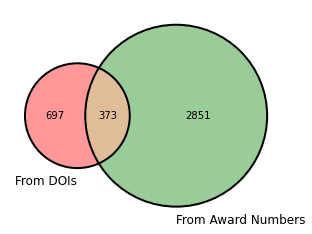

In [5]:
plot_venn(from_dois['doi'], from_award_numbers['doi'], 'From DOIs', 'From Award Numbers')

Assuming the 'From DOIs' set is both complete and accurate (it has perfect precision and recall), the precision and recall scores for our automated query would be:

In [30]:
print('Precision = {}'.format(373/(2851+373)))
print('Recall = {}'.format(373/(697+373)))

Precision = 0.11569478908188585
Recall = 0.3485981308411215


Not great. As expected there are many false positives. At this point it may be worthwhile to question the completeness of the DOI dataset. It is clear that all of the publications harvested from the CZO site are relevant but it may be a false assumption to think that the set is also complete. We know little about the process through which this list came to exist. To improve recall, we can add more terms to the query, things like site names, grid ids, and rrids come to mind but our already poor precision score would decrease further. Perhaps we can build a training set from the CZO data to train a classifier that we can use to eliminate many of the false positives from our automated query. To do so we can label each publication as 'relevant' or 'not-relevant'. We have 1070 'relevant' publications to start with. We need probably 10 times that number of 'not-relevant' publications, since the set of 'not-relevant' publications needs to include learning examples from all other domains except the earth sciences.

Lets load a data set of publications gathered from searching random words with strong associations to other domains.

In [43]:
# Load the data harvested from terms with strong associations to other domains
non_relevant = pd.read_csv('output/not_relevant.csv', delimiter=',')
non_relevant.head()

,title,authors,id,doi,publisher,journal,volume,issue,pages,pub_year,concepts,abstract,acknowledgements,funders,research_org_cities,research_org_names,research_org_state_names,research_orgs,provenance,pub_harvested_date
0,Financial Technology Regulation in Malaysia an...,NaN,pub.1137575199,10.12928/ijiefb.v3i2.2703,Universitas Ahmad Dahlan,"{'id': 'jour.1359381', 'title': 'Ihtifaz Journ...",3,2,67-87,2021,"['technology regulation', 'lack of jurisdictio...",Introduction to The Problem: The era of innova...,NaN,NaN,"[{'id': 1735161, 'name': 'Kuala Lumpur'}, {'id...",['IIUM Institute of Islamic Banking and Financ...,NaN,"[{'id': 'grid.444626.6', 'types': ['Education'...",dimensions,15/07/2021 09:57:50
1,The Effect of the Installation Angle of the Sk...,NaN,pub.1135344436,10.12928/irip.v3i2.2074,Universitas Ahmad Dahlan,"{'id': 'jour.1377959', 'title': 'Indonesian Re...",3,2,35-39,2021,"['sky brightness', 'western horizon', 'eastern...",Measuring the brightness of the night sky and ...,NaN,NaN,"[{'id': 1214520, 'name': 'Medan'}]",['Universitas Muhammadiyah Sumatera Utara'],NaN,"[{'id': 'grid.443842.d', 'types': ['Education'...",dimensions,15/07/2021 09:57:50
2,Perancangan Sistem Data Hasil Belajar Murid SM...,NaN,pub.1134641628,10.32493/informatika.v5i4.7675,Universitas Pamulang,"{'id': 'jour.1378245', 'title': 'Jurnal Inform...",5,4,592,2021,"['senior high school', 'high school', 'Islamic...",SMAI Said Na'um is a senior secondary educatio...,NaN,NaN,NaN,NaN,NaN,NaN,dimensions,15/07/2021 09:57:50
3,Religious Education Policy in Public Schools D...,NaN,pub.1136673480,10.19105/karsa.v28i2.3936,Institut Agama Islam Negeri Madura,"{'id': 'jour.1153536', 'title': 'KARSA Journal...",28,2,390-409,2021,"['religious education', 'accommodative policy'...",The new order government policy about religiou...,NaN,NaN,NaN,NaN,NaN,NaN,dimensions,15/07/2021 09:57:50
4,Estimating the oil revenues of Iran premised o...,NaN,pub.1139332393,10.22363/2313-2329-2021-29-2-451-462,Peoples' Friendship University of Russia,"{'id': 'jour.1299696', 'title': 'RUDN Journal ...",29,2,451-462,2021,"['foreign policy', 'bilateral relations', 'pre...",The Islamic Revolution of 1979 has filpped Ira...,NaN,NaN,"[{'id': 524901, 'name': 'Moscow'}]",['Diplomatic Academy of the Russian Foreign Mi...,NaN,"[{'id': 'grid.445840.9', 'types': ['Education'...",dimensions,15/07/2021 09:57:50


The concepts column is what we will use as features for training and prediction. So let's remove any rows where that column is empty then write the concepts tokens to a file adding a 'non-relevant' label in the process.

In [161]:
def training_data_from_df(df, label, out_file):
    df['concepts'].replace('', np.nan, inplace=True)
    df.dropna(subset=['concepts'], inplace=True)
    np.savetxt('temp.txt', df.concepts, fmt='%s')
    features = open('temp.txt', "r")
    with open('{}'.format(out_file), "w") as out:
        for line in features.readlines():
            out.write('__label__{} {}'.format(label, line.replace("['", "'").replace("']", "'").replace(", ", " ")))
    os.remove('temp.txt')  

In [162]:
training_data_from_df(from_dois, 'relevant', 'output/relevant.txt')

In [163]:
def merge_files(file_one, file_two, out_file):
    one = open(file_one, "r")
    two = open(file_two, "r")
    with open('{}'.format(out_file), "w") as out:
        for line in one.readlines():
            out.write(line)
        for line in two.readlines():
            out.write(line)    

In [164]:
merge_files('output/relevant.txt', 'output/non-relevant.txt', 'output/earth-sciences.txt')

Now that we have an initial dataset to train our model, lets break it into training and validation sets and give it a try.

In [174]:
with open('output/earth-sciences.txt', 'r') as f:
    data = f.read().split('\n')
    print(len(data))

random.shuffle(data)

with open('output/earth-sceinces.train', 'w') as train:
    for i in data[1400:]:
        train.write(i+'\n')

with open('output/earth-sceinces.valid', 'w') as valid:
    for i in data[:1400]:
        valid.write(i+'\n')

13840


In [175]:
model = fasttext.train_supervised(input='output/earth-sceinces.train')

In [176]:
model.test('output/earth-sceinces.valid')

(1400, 0.9878571428571429, 0.9878571428571429)

The outputs are the total number of publications (12,439), precision, and recall. Precision and recall are the same since there is only one label. With multiple labels, they would likely diverge. 98% without any effort to improve the training data or the model is a great start and a confirmation that this is an ideal candidate for machine learning. This means we could use this model to remove 9 out of 10 false positives or, put another way, we could reduce the manual labor needed by 98%. The cost is that we lose 8% of everything we label 'not-relevant', but we should keep in mind that we can also expand our search terms since we will be less concerned about false positives. In other words we can cast the net much wider in our query strategy, so recall will be higher to begin with. 

We should look at this as a proof of concept. It needs work before we can apply it in all instances where we need to collect a set of publications related to a shared facility or research network, but it is a promising start.

In [188]:
# Use all the training data we have
with open('output/earth-sceinces.final', 'w') as final:
    for i in data:
        final.write(i+'\n')

final_model = fasttext.train_supervised(input='output/earth-sceinces.final')

In [189]:
def predict_relevance(features):
    return str(final_model.predict(features)[0]).replace("'__label__", '').replace("',", '').replace('(', '').replace(')', '')

In [190]:
from_award_numbers['relevance'] = from_award_numbers.apply(lambda row : predict_relevance(str(row['concepts']).replace("['", "'").replace("']", "'").replace(", ", " ")), axis = 1)

In [191]:
from_award_numbers.head()


,title,author_list,dimensions_id,doi,doi_url,publisher,journal,volume,issue,pages,pub_year,concepts,provenance,award_number,award_date,pub_harvested_date,relevance
0,Publishers' International ISBN Directory 2015,NaN,pub.1137290625,10.1515/9783110337358,https://doi.org/10.1515/9783110337358,De Gruyter,NaN,NaN,NaN,NaN,2021.0,[],dimensions,636043,6/1/2007,18/06/2021 12:09:09,non-relevant
1,コルシカ語方言学の諸問題,NaN,pub.1137226545,10.15083/00080119,https://doi.org/10.15083/00080119,NaN,NaN,27,NaN,117-130,2020.0,NaN,dimensions,636043,6/1/2007,18/06/2021 12:09:09,non-relevant
2,『鏡子の家』における日常性の問題,NaN,pub.1137224479,10.15083/00080116,https://doi.org/10.15083/00080116,NaN,NaN,27,NaN,71-89,2020.0,NaN,dimensions,636043,6/1/2007,18/06/2021 12:09:09,non-relevant
3,Occurrence of marine sponge Chelonaplysilla de...,NaN,pub.1114352198,10.1101/636043,https://doi.org/10.1101/636043,Cold Spring Harbor Laboratory,"{'id': 'jour.1293558', 'title': 'bioRxiv'}",NaN,NaN,636043,2019.0,"['Nicobar Islands', 'Indian Ocean', 'biodivers...",dimensions,636043,6/1/2007,18/06/2021 12:09:09,non-relevant
4,Diversity and preserved shell coloration patte...,NaN,pub.1104259488,10.1017/jpa.2017.153,https://doi.org/10.1017/jpa.2017.153,Cambridge University Press (CUP),"{'id': 'jour.1026144', 'title': 'Journal of Pa...",92,5,804-837,2018.0,"['coloration patterns', 'Gatun Formation', 'fu...",dimensions,636043,6/1/2007,18/06/2021 12:09:09,non-relevant


In [192]:
# Remove non-relevant publicaitons from the dataframe
df_filtered = from_award_numbers[~from_award_numbers.relevance.str.contains('non-relevant')]

In [193]:
df_filtered.head()

,title,author_list,dimensions_id,doi,doi_url,publisher,journal,volume,issue,pages,pub_year,concepts,provenance,award_number,award_date,pub_harvested_date,relevance
9,Effect of Salt Concentrations on the Hydraulic...,NaN,pub.1135188020,10.5109/4707,https://doi.org/10.5109/4707,NaN,"{'id': 'jour.1222612', 'title': 'Journal of th...",51,1,37-43,2006.0,"['basalt soils', 'hydraulic conductivity', 'so...",dimensions,636043,6/1/2007,18/06/2021 12:09:09,relevant
48,Soil moisture response to snowmelt timing in m...,NaN,pub.1003809848,10.1002/hyp.10400,https://doi.org/10.1002/hyp.10400,Wiley,"{'id': 'jour.1043737', 'title': 'Hydrological ...",29,12,2782-2798,2014.0,"['earlier snow disappearance', 'soil moisture ...",dimensions,724958,9/1/2009,18/06/2021 12:09:09,relevant
50,LiDAR‐derived snowpack data sets from mixed co...,NaN,pub.1023757495,10.1002/2013wr013935,https://doi.org/10.1002/2013wr013935,American Geophysical Union (AGU),"{'id': 'jour.1081604', 'title': 'Water Resourc...",50,3,2749-2755,2014.0,"['Critical Zone Observatory', 'western United ...",dimensions,724958,9/1/2009,18/06/2021 12:09:09,relevant
72,Soil moisture response to snowmelt timing in m...,NaN,pub.1003809848,10.1002/hyp.10400,https://doi.org/10.1002/hyp.10400,Wiley,"{'id': 'jour.1043737', 'title': 'Hydrological ...",29,12,2782-2798,2014.0,"['earlier snow disappearance', 'soil moisture ...",dimensions,724960,9/15/2007,18/06/2021 12:09:10,relevant
73,LiDAR‐derived snowpack data sets from mixed co...,NaN,pub.1023757495,10.1002/2013wr013935,https://doi.org/10.1002/2013wr013935,American Geophysical Union (AGU),"{'id': 'jour.1081604', 'title': 'Water Resourc...",50,3,2749-2755,2014.0,"['Critical Zone Observatory', 'western United ...",dimensions,724960,9/15/2007,18/06/2021 12:09:10,relevant


Now lets plot our venn diagram again to see how well we did.

Total: 1507


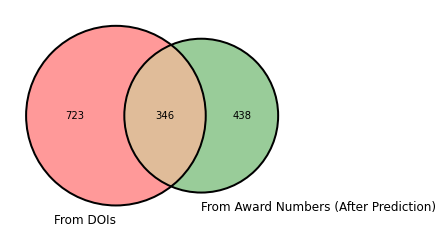

In [216]:
plot_venn(from_dois['doi'], df_filtered['doi'], 'From DOIs', 'From Award Numbers (After Prediction)')

Lets compare this to our initial results:

In [204]:
print('Precision went from {}% to {}%'.format(round((373/(373+2851))*100),round((346/(346+438)*100))))
print('Recall went from {}% to {}%'.format(round((373/(373+697))*100),round((346/(346+723)*100))))

Precision went from 12% to 44%
Recall went from 35% to 32%


We must also bear in mind though that 'From DOIs' is not a gold standard data set after all. It is likely perfectly precise but does not have perfect recall. Meaning there is a chance that the green area in the Venn diagram above contains relevant publications. If so, the CZO network is missing an opportunity to report all of its research. Lets export these and take a look. 

In [221]:
final_doi_set = set(df_filtered['doi']) - set(from_dois['doi'])
print(len(final_doi_set))

438


In [230]:
w = csv.writer(open("output/non-relevant-dois.csv",'w'))
w.writerow(['doi'])
for i in final_doi_set:
        w.writerow([i])